In [2]:
import pandas as pd 
import numpy as np
import re
import pymystem3
import pymorphy2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.text import TextCollection
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
%matplotlib notebook

[nltk_data] Downloading package punkt to /home/alekum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alekum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%%time
# NOT NECESSARY TO RUN: JUST PLAYING AROUND THE METHODS
def strip_tags(file):
    with open('stripped_'+file, mode='w+') as fd1:
        with open(file, mode='r') as fd:
            for line in fd:
                fd1.write(BeautifulSoup(line, 'lxml').get_text())
                
strip_tags('train.csv')
strip_tags('test.csv')
# strip_tags('other.csv')

# train_csv = pd.read_csv('train.csv', index_col='id', sep='\t')
# test_csv  = pd.read_csv('test.csv', index_col='id', sep='\t')
# other_csv = pd.read_csv('other.csv', sep='\t')

CPU times: user 8min 16s, sys: 1.72 s, total: 8min 18s
Wall time: 8min 19s


In [5]:
%%time
# NOT NECESSARY TO RUN: JUST PLAYING AROUND THE METHODS
def regex_stripper(file):
    re_killer = re.compile('<.*?>')
    with open('stripped1_'+file, mode='w+') as fd1:
        with open(file, mode='r') as fd:
            for line in fd:
                fd1.write(re.sub(re_killer, '', line))

regex_stripper('test.csv')

CPU times: user 5.46 s, sys: 506 ms, total: 5.96 s
Wall time: 6.39 s


In [3]:
# df_train = pd.read_csv('stripped_train.csv', sep='\t', index_col='id')

In [4]:
# df_test = pd.read_csv('stripped1_test.csv', sep='\t', index_col='id')

In [85]:
# df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199957 entries, 0 to 199999
Data columns (total 3 columns):
name           199957 non-null object
description    199952 non-null object
target         199947 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.1+ MB


In [ ]:
# df_test.info()

In [2]:
df_train_raw = pd.read_csv('train.csv', sep='\t', index_col='id')
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 3 columns):
name           200000 non-null object
description    200000 non-null object
target         200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.1+ MB


In [3]:
df_test_raw = pd.read_csv('test.csv', sep='\t', index_col='id')
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170179 entries, 200000 to 370178
Data columns (total 2 columns):
name           170179 non-null object
description    170179 non-null object
dtypes: object(2)
memory usage: 3.9+ MB


In [4]:
df_train_raw['description'] = df_train_raw['description'].map(lambda value: BeautifulSoup(value, 'lxml').text)
df_train_raw['name'] = df_train_raw['name'].map(lambda value: BeautifulSoup(value, 'lxml').text)

In [5]:
df_test_raw['description'] = df_test_raw['description'].map(lambda value: BeautifulSoup(value, 'lxml').text)
df_test_raw['name'] = df_test_raw['name'].map(lambda value: BeautifulSoup(value, 'lxml').text)

In [10]:
df_train_raw.head()
df_train_raw.to_csv('cleared_train.csv', sep='\t', index=True)

In [8]:
df_test_raw.head()
df_test_raw.to_csv('cleared_test.csv', sep='\t', index=True)

In [11]:
np.where(np.isnan(df_train_raw['target']) == True)

(array([], dtype=int64),)

In [3]:
df_train = pd.read_csv('cleared_train.csv', sep='\t', index_col='id')

In [4]:
df_test = pd.read_csv('cleared_test.csv', sep='\t', index_col='id')

In [7]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 3 columns):
name           200000 non-null object
description    200000 non-null object
target         200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 170179 entries, 200000 to 370178
Data columns (total 2 columns):
name           170179 non-null object
description    170179 non-null object
dtypes: object(2)
memory usage: 3.9+ MB


(None, None)

In [8]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)
X_test  = df_test

X_test['sample'] = 'test'
X_train['sample'] = 'train'

df = X_train.append(X_test)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370179 entries, 0 to 370178
Data columns (total 3 columns):
name           370179 non-null object
description    370179 non-null object
sample         370179 non-null object
dtypes: object(3)
memory usage: 11.3+ MB


In [10]:
df['name'].value_counts()

Менеджер по продажам                                           11643
Продавец-консультант                                            9644
Торговый представитель                                          9591
Менеджер по работе с клиентами                                  6437
Продавец-кассир                                                 2846
Системный администратор                                         2792
Мерчендайзер                                                    2762
Маркетолог                                                      2108
Программист 1С                                                  1897
Менеджер по оптовым продажам                                    1868
Руководитель отдела продаж                                      1619
Инженер-конструктор                                             1615
Продавец                                                        1485
Фрезеровщик                                                     1298
Кассир                            

In [11]:
# Get rid of from all non helpful things from the text: по, (текст какой-то в скобках), slashes and etc
re_parentheses_trash_ripper = re.compile("[!#$%&'*+.,^_`|~:;]|\(.*?\)", flags=re.IGNORECASE)
re_slash_dash_replacer = re.compile("[-/[\\]]")
re_double_quotes_ripper = re.compile("\".*?\"")
re_html_escapers = re.compile("&\w+;")
re_punctuation_ripper = re.compile("[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", flags=re.IGNORECASE)

def erase_chars_by_pattern(_text, _re_compiled_pattern, _substitution=''):
    _text = re.sub(_re_compiled_pattern, 
                   _substitution, 
                   str(_text)).strip()
    return _text

In [12]:
def preprocessing_data(df):
    # I am too far away from doing it more efficiently putting it into pipeline(loop) with line of the parameters
    # so, suck it up=)
    df['name'] = df['name'].map(lambda value: erase_chars_by_pattern(value, re_parentheses_trash_ripper))
    df['name'] = df['name'].map(lambda value: erase_chars_by_pattern(value, re_slash_dash_replacer, ' '))
    df['name'] = df['name'].map(lambda value: erase_chars_by_pattern(value, re_double_quotes_ripper))
    df['name'] = df['name'].map(lambda value: str(value).lower())
    
    df['description'] = df['description'].map(lambda value: erase_chars_by_pattern(value, re_slash_dash_replacer, ' '))
    df['description'] = df['description'].map(lambda value: erase_chars_by_pattern(value, re_punctuation_ripper))
    df['description'] = df['description'].map(lambda value: erase_chars_by_pattern(value, re_html_escapers))
    df['description'] = df['description'].map(lambda value: str(value).lower())
    df['description'] = df['description'].map(lambda value: ' '.join([word for word in value.split() if word.isalnum()]))
    
    return df

In [13]:
df.pipe(preprocessing_data).head()

,name,description,sample
id,,,
0,заведующий отделом секцией в магазин york,в новый магазин york хозтовары приглашаем на п...,train
1,наладчик станков и манипуляторов с пу,обязанностиработа на токарных станках с чпу ta...,train
2,разработчик с,требования опыт программирования на с знание б...,train
3,фрезеровщик,условия на работу вахтовым методом в г калуга ...,train
4,мерчендайзер продавец консультант,компания палладиум стандарт признанный лидер п...,train


In [15]:
X_train.shape, X_test.shape, X_train.shape[0] + X_test.shape[0], y_train.shape

((200000, 3), (170179, 3), 370179, (200000,))

In [16]:
stem   = pymystem3.Mystem()
morph  = pymorphy2.MorphAnalyzer()

In [17]:
_stopwords = []
_stopwords.extend(stopwords.words('english'))
_stopwords.extend(stopwords.words('russian'))

def is_digit(g):
    try:
        float(g)
    except ValueError:
        return False
    return True

mystem_tokenizer = lambda text: [w for w in stem.lemmatize(text) if w.isalnum() and w not in _stopwords and not is_digit(w)]
morphy_tokenizer = lambda text: [morph.parse(w)[0].normal_form for w in text.split() if w.isalnum() and not is_digit(w) and w not in _stopwords]
nltk_tokenizer   = lambda text: [w for w in nltk.word_tokenize(text) if w.isalnum() and not is_digit(w) and w not in _stopwords]

def get_count_vect_words(_cv) -> list:
    return [x[0] for x in sorted(_cv.vocabulary_.items(), key=lambda x: x[1])]

def stemmer_runner(stemmers, text):
    return [stemmer(text) for stemmer in stemmers]

In [19]:
stemmer_runner([mystem_tokenizer, morphy_tokenizer, nltk_tokenizer], df['description'][234])

[['должностной',
  'обязанность',
  'прием',
  'выдача',
  'заказ',
  'работа',
  'касса',
  'терминал',
  'оплата',
  'сдача',
  'инкассация',
  'осуществление',
  'товародвижение',
  'программа',
  '1с',
  'торговля',
  'склад',
  'требование',
  'доброжелательность',
  'коммуникабельность',
  'приоритет',
  'скорость',
  'качество',
  'работа',
  'неоспоримый',
  'преимущество',
  'знание',
  'программа',
  '1с',
  'опыт',
  'работа',
  'касса',
  'значительный',
  'плюс',
  'условие',
  'официальный',
  'трудоустройство',
  'тк',
  'рф',
  'оплачивать',
  'отпуск',
  'больничный',
  'лист',
  'заработный',
  'плата',
  'окладбонус',
  'сменный',
  'график',
  'место',
  'работа',
  'москва',
  'м',
  'багратионовский',
  'тк',
  'горбушка'],
 ['должностной',
  'обязанность',
  'приём',
  'выдача',
  'заказ',
  'работа',
  'касса',
  'терминал',
  'оплата',
  'сдача',
  'инкассация',
  'осуществление',
  'товародвижение',
  'программа',
  '1с',
  'торговля',
  'склад',
  'требование

In [20]:
df['combined'] = df[['name', 'description']].apply(lambda x: ' '.join(x), axis=1)

In [21]:
_df = df.copy()

In [22]:
df = df.drop(['name', 'description'], axis=1)

In [23]:
cv = CountVectorizer(tokenizer=morphy_tokenizer, ngram_range=(1,1))
tfidf = TfidfTransformer(smooth_idf=False, norm=False)

In [24]:
cvm = cv.fit_transform(df['combined'])

In [25]:
%time
cvm_wcols = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda v: v[1])]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [26]:
%time
tfidfm = tfidf.fit_transform(cvm)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [27]:
tfidfm.shape, cvm.shape, len(cvm_wcols)

((370179, 221796), (370179, 221796), 221796)

In [56]:
# cv_name = CountVectorizer(tokenizer=morphy_tokenizer, ngram_range=(1,2))
# cv_desc = CountVectorizer(tokenizer=morphy_tokenizer, ngram_range=(1,2))
# tfidf_name = TfidfTransformer(smooth_idf=False, norm=False)
# tfidf_desc = TfidfTransformer(smooth_idf=False, norm=False)

# cvm_name = cv_name.fit_transform(l_name)
# cvm_name_wcols = get_count_vect_words(cv_name)
# cvm_desc = cv_desc.fit_transform(l_description)
# cvm_desc_wcols = get_count_vect_words(cv_desc)
# tfidf_matrix_name = tfidf_name.fit_transform(cvm_name)
# tfidf_matrix_desc = tfidf_desc.fit_transform(cvm_desc)




# tfidf_mname_train = tfidf_matrix_name[:199957]
# tfidf_mname_test  = tfidf_matrix_name[200000:]
# tfidf_mdesc_train = tfidf_matrix_desc[:199957]
# tfidf_mdesc_test  = tfidf_matrix_desc[200000:]

# КАК ОБЪЕДИНИТЬ ТЕПЕРЬ ДВЕ ВЫБОРКИ ЧТОБЫ ПОЛУЧИТЬ ТАКОЕ 
# df['_id'], tfidf_matrix_name, tfidf_matrix_desc, sample, 
# Чтобы потом засплитить. на выборки нормально. ???????????????

# X_train.shape[0] + X_test.shape[0], tfidf_matrix_desc.shape[0], tfidf_matrix_name.shape[0], df.shape[0]

In [28]:
len(X_train), len(y_train), len(X_test), len(df)

(200000, 200000, 170179, 370179)

In [29]:
cvm_train = cvm[:len(y_train)]
cvm_test  = cvm[len(y_train):]
tfidfm_train = tfidfm[:len(y_train)]
tfidfm_test = tfidfm[len(y_train):]

cvm_train.shape[0] + cvm_test.shape[0], tfidfm_train.shape[0] + tfidfm_test.shape[0]

(370179, 370179)

In [30]:
def get_some_info_SM(sparse_matrix):
    print ('Shape of Sparse Matrix: ', sparse_matrix.shape)
    print ('Amount of Non-Zero occurences: ', sparse_matrix.nnz)
    print ('sparsity: %.2f%%' % (100.0 * sparse_matrix.nnz /
                             (sparse_matrix.shape[0] * sparse_matrix.shape[1])))
    print('\n')

In [31]:
print("===> cvm_train"); get_some_info_SM(cvm_train)

print("===> cvm_train"); get_some_info_SM(cvm_test)

print("===> cvm_train"); get_some_info_SM(tfidfm_train)

print("===> cvm_train"); get_some_info_SM(tfidfm_test)

===> cvm_train
Shape of Sparse Matrix:  (200000, 221796)
Amount of Non-Zero occurences:  17447081
sparsity: 0.04%


===> cvm_train
Shape of Sparse Matrix:  (170179, 221796)
Amount of Non-Zero occurences:  14857488
sparsity: 0.04%


===> cvm_train
Shape of Sparse Matrix:  (200000, 221796)
Amount of Non-Zero occurences:  17447081
sparsity: 0.04%


===> cvm_train
Shape of Sparse Matrix:  (170179, 221796)
Amount of Non-Zero occurences:  14857488
sparsity: 0.04%




In [32]:
def tfidf_for_word(w):
    return tfidf.idf_[cv.vocabulary_[w]] 

In [33]:
[(w, tfidf_for_word(w)) for w in cvm_wcols[111600:111610]]

[('карпинск', 12.212304038984445),
 ('карпинский', 11.742300409738709),
 ('карповка', 13.1285947708586),
 ('карповский', 12.02998248219049),
 ('карпоратив', 12.723129662750436),
 ('каррента', 13.821741951418545),
 ('карринг', 13.821741951418545),
 ('каррирование', 12.723129662750436),
 ('карсунский', 13.821741951418545),
 ('карт2', 10.877302972252105)]

In [34]:
np.where(np.isnan(y_train) == True)

(array([], dtype=int64),)

In [35]:
from sklearn.utils import check_X_y

In [36]:
check_X_y(tfidfm_train, y_train, accept_sparse='csr', dtype=tfidfm_train.dtype, order="C")

(<200000x221796 sparse matrix of type '<class 'numpy.float64'>'
 	with 17447081 stored elements in Compressed Sparse Row format>,
 array([1, 0, 0, ..., 1, 1, 0]))

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()


In [63]:
lr1 = LogisticRegression()

In [50]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(tfidfm_train, 
                                                                            y_train, 
                                                                            test_size=0.2, 
                                                                            random_state=18)

In [51]:
lr.fit(X_train_train, y_train_train)
predict_lr = lr.predict(X_train_test)
predict_proba_lr = lr.predict_proba(X_train_test)

In [61]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(cvm_train, 
                                                                            y_train, 
                                                                            test_size=0.2, 
                                                                            random_state=18)


In [64]:
lr1.fit(X_train_train, y_train_train)
predict_lr1 = lr1.predict(X_train_test)
predict_proba_lr1 = lr1.predict_proba(X_train_test)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
apr_results = { 
    'accuracy' : accuracy_score(y_train_test, predict_lr), 
    'precision' : precision_score(y_train_test, predict_lr),
    'recall_score' : recall_score(y_train_test, predict_lr)
}

apr_results1 = { 
    'accuracy' : accuracy_score(y_train_test, predict_lr1), 
    'precision' : precision_score(y_train_test, predict_lr1),
    'recall_score' : recall_score(y_train_test, predict_lr1)
}

apr_results, apr_results1

({'accuracy': 0.94965,
  'precision': 0.9432028319332171,
  'recall_score': 0.9500292693310628},
 {'accuracy': 0.9605,
  'precision': 0.9518034336115924,
  'recall_score': 0.9647703687935714})

(-0.01, 1.01)

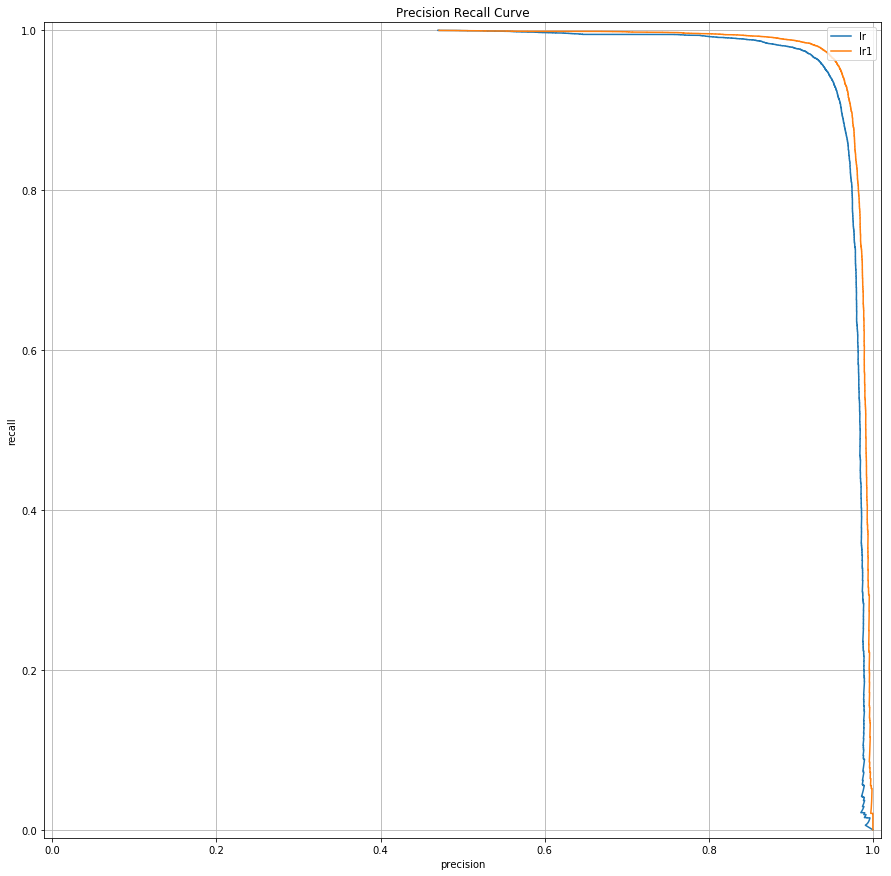

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

precision_prc_lr, recall_prc_lr, treshold_prc_lr = precision_recall_curve(y_train_test, predict_proba_lr[:,1])
precision_prc_lr1, recall_prc_lr1, treshold_prc_lr1 = precision_recall_curve(y_train_test, predict_proba_lr1[:,1])

plt.figure(figsize=(15, 15))
plt.plot(precision_prc_lr, recall_prc_lr, label='lr')
plt.plot(precision_prc_lr1, recall_prc_lr1, label='lr1')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.xlabel('precision')
plt.grid(True)
plt.title('Precision Recall Curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

{'lr': 0.9829614426611761} {'lr1': 0.9891939299317414}


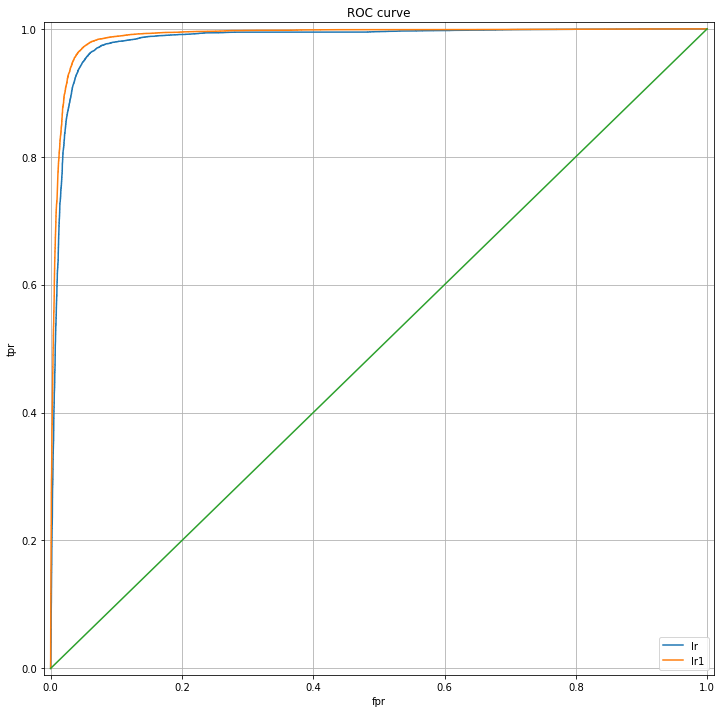

In [70]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train_test, predict_proba_lr[:,1])
fpr_lr1, tpr_lr1, thresholds_lr1 = roc_curve(y_train_test, predict_proba_lr1[:,1])
plt.figure(figsize=(12, 12))
plt.plot(fpr_lr, tpr_lr, label='lr')
plt.plot(fpr_lr1, tpr_lr1, label='lr1')
plt.legend()
plt.plot([1.0, 0], [1.0, 0])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

results = {'lr' : roc_auc_score(y_train_test, predict_proba_lr[:,1])} 
results1 = {'lr1' : roc_auc_score(y_train_test, predict_proba_lr1[:,1])} 
print(results, results1)

In [55]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv0 = StratifiedKFold(n_splits=15, shuffle=True, random_state=100)
cross_val_score(lr, X_train_test, y_train_test, scoring='roc_auc', cv=cv0.get_n_splits())

array([0.97335842, 0.97726418, 0.97700737, 0.97909854, 0.97629565,
       0.97699326, 0.97732119, 0.97709514, 0.98308952, 0.97692215,
       0.98218392, 0.97572427, 0.97392235, 0.98022344, 0.98141742])

In [71]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv1 = StratifiedKFold(n_splits=15, shuffle=True, random_state=100)
cross_val_score(lr1, X_train_test, y_train_test, scoring='roc_auc', cv=cv1.get_n_splits())

array([0.98226717, 0.98736724, 0.98270346, 0.98513158, 0.98474383,
       0.9848426 , 0.98389269, 0.98513186, 0.98841649, 0.98310363,
       0.98800361, 0.98275461, 0.98182088, 0.98523324, 0.98720914])

In [56]:
predicted_test = lr.predict(tfidfm_test)

In [72]:
predicted_test1 = lr1.predict(cvm_test)

In [57]:
combined_results_lr = list(zip(df_test.index, predicted_test))

In [73]:
combined_results_lr1 = list(zip(df_test.index, predicted_test1))

In [58]:
predicred_test_df = pd.DataFrame(combined_results_lr, columns=['id', 'target'])

In [74]:
predicred_test_df1 = pd.DataFrame(combined_results_lr1, columns=['id', 'target'])

In [59]:
import time 
submission_filename = 'hw06_kaggle_submission_{0}.csv'.format(str(time.time()).replace('.', '_'))
predicred_test_df.to_csv(submission_filename, sep=',', index=False, columns=['id', 'target'])

In [75]:
import time 
submission_filename = 'hw06_kaggle_submission_lr1_{0}.csv'.format(str(time.time()).replace('.', '_'))
predicred_test_df1.to_csv(submission_filename, sep=',', index=False, columns=['id', 'target'])

In [77]:
from sklearn.metrics import classification_report
print (classification_report(y_train, lr.predict(tfidfm_train)))
print (classification_report(y_train, lr.predict(cvm_train)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    106436
          1       0.98      0.99      0.99     93564

avg / total       0.99      0.99      0.99    200000

             precision    recall  f1-score   support

          0       0.99      0.94      0.97    106436
          1       0.94      0.99      0.96     93564

avg / total       0.97      0.96      0.97    200000



In [79]:
from sklearn.metrics import classification_report
print (classification_report(y_train, lr1.predict(tfidfm_train)))
print (classification_report(y_train, lr1.predict(cvm_train)))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97    106436
          1       0.98      0.95      0.96     93564

avg / total       0.97      0.97      0.97    200000

             precision    recall  f1-score   support

          0       0.99      0.98      0.98    106436
          1       0.97      0.98      0.98     93564

avg / total       0.98      0.98      0.98    200000

